In [1]:
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import os
import pickle
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
#inf_df = pd.read_parquet(r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\results\anom_df_inference_all_sats_0.parquet")
#train_df = pd.read_parquet(r"C:\Users\dk412\Desktop\David\Python Projects\RusSat\dataout_HPC\MODEL_training_tle_data.parquet")
combat_df = pd.read_parquet(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\results\anom_df_combat_all_sats_0.parquet')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Outlier Detection - Skip this if not doing Model Evaluation (it's slow ~40 mins for combat_df on CPU)

In [ ]:
cols = ['inclination','ra_of_asc_node', 'eccentricity', 'arg_of_perigee', 'mean_anomaly', 'mean_motion']

def calculate_outlier(df, column_nm, threshold = 2, method = 'iqr'):
    z_scores = np.abs((df[column_nm] - df[column_nm].mean())/df[column_nm].std())
    df[f'outlier_{column_nm}'] = (z_scores > threshold).astype(int)

    if method=='iqr':
        # IQR Method returned ~ 2% outlier
        q1 = df[column_nm].quantile(0.25)
        q3 = df[column_nm].quantile(0.75)
        iqr = q3 - q1
        df[f'outlier_{column_nm}'] = ((df[column_nm] < (q1 - 1.5 * iqr)) | (df[column_nm] > (q3 + 1.5 *iqr))).astype(int)
    
    elif method =='zscore':
        # ~ 5% outlier with threshold=2
        z_scores = np.abs((df[column_nm] - df[column_nm].mean())/df[column_nm].std())
        df[f'outlier_{column_nm}'] = (z_scores > threshold).astype(int)

    elif method =='mad':
        #~9% outliers with threshold=2 
        median = df[column_nm].median()
        mad = median_abs_deviation(df[column_nm])
        modified_z = 0.6745 * (df[column_nm] - median) / mad
        df[f'outlier_{column_nm}'] = (abs(modified_z) > threshold).astype(int)

    else:
        print('Not a valid outlier detection method')

    df['outlier'] = (df.iloc[:, -6:] == 1).any(axis=1).astype(int)

count = 0 
tle_df = pd.DataFrame()
for id in inf_df['NORAD_CAT_ID'].unique():
    bysat_df = inf_df[inf_df['NORAD_CAT_ID']==id]
    for c in cols:
        calculate_outlier(bysat_df,c, threshold = 2, method = 'mad')
    tle_df = pd.concat([tle_df, bysat_df], axis=0)
    count += 1
    progress = (count/len(combat_df['NORAD_CAT_ID'].unique())) * 100
    print(f"Outlier calculation is {progress:.2f}% complete")

NASA Discpiline Data & tle_df preproces

In [4]:
nasa_df = pd.read_excel(r'C:\Users\dk412\Desktop\David\Python Projects\RusSat\dataout_HPC\NASA_SSCDA_satdiscipline.xlsx')
nasa_df=nasa_df.fillna(0)
nasa_df['Spacecraft Name'] = nasa_df['Spacecraft Name'].astype(str)
nasa_df['Spacecraft Name'] = nasa_df['Spacecraft Name'].str.upper()

In [5]:
#combat_df['SATNAME'] = combat_df['SATNAME'].astype(int)
#nasa_df['Spacecraft Name']  = satcat_df['NORAD_CAT_ID'].astype(int)
tle_df = combat_df.copy(deep=False)

tle_df = tle_df.merge(
    nasa_df[['Spacecraft Name', 'Discipline']], 
    left_on='SATNAME',
    right_on='Spacecraft Name',
    how='left'
)

tle_df = tle_df.drop('Spacecraft Name', axis=1)

In [6]:
tle_df['anomaly_ind'] = (tle_df['anom_count'] >= 1).astype(int)
tle_df['datetime'] = pd.to_datetime(tle_df['datetime'])
tle_df['Discipline'] = tle_df['Discipline'].fillna('Unidentified')

Model Evaluation - Needs outlier column and train_df 

In [ ]:
eval_split = train_df.shape[0]+tle_df.shape[0]
test_size = tle_df.shape[0]/eval_split
train_size = train_df.shape[0]/eval_split
print(f'Test train split:\n\tTest Size: {tle_df.shape[0]}\t{test_size*100:.2f}%\n\tTrain Size: {train_df.shape[0]}\t{train_size*100:.2f}%\n')

prediction_columns = ['anomaly_ind']

def evaluate_binary_classifier(y_true, y_pred, model_name='Model'):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1': f1_score
    }
    
    results = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == 'Accuracy':
            score = metric_func(y_true, y_pred)
        else:
            score = metric_func(y_true, y_pred, average='weighted')
        results[metric_name] = score
        print(f"{metric_name} for {model_name}: {score:.3f}")
    
    return results

for col in prediction_columns:
    results = evaluate_binary_classifier(tle_df['outlier'], tle_df[col], 'cumulative_models')

Hypothesis Testing

In [ ]:
############ hypothesis testing on overall number of anomalies ['anomaly_ind']

from scipy import stats


def get_anomaly_rate(df):
    anom_cols = df.columns.str.startswith('anom')
    anom_data = df.iloc[:, anom_cols]
    df['anom_count'] = anom_data.sum(axis=1)
    df['anomaly_ind'] = (df['anom_count'] >= 1).astype(int)
    total_observations = len(df)
    anomaly_count = len(df[df['anomaly_ind'] == 1])
    
    return anomaly_count / total_observations if total_observations > 0 else 0

def perform_chi_square_test(period1, period2):
    table = [
        [len(period1[period1['anomaly_ind'] == 1]), len(period1[period1['anomaly_ind'] == 0])],
        [len(period2[period2['anomaly_ind'] == 1]), len(period2[period2['anomaly_ind'] == 0])]]
    
    chi2, p_value = stats.chi2_contingency(table)[:2]
    
    return chi2, p_value

def hypoth_test(col):
    chi_square_lst = []
    p_value_lst = []
    base_anom_rate_lst = []
    lead_anom_rate_lst = []
    purpose_lst = []

    for p in tle_df[col].unique():
        baseline_period = tle_df[(tle_df['datetime'] <= '2021-08-24') & (tle_df[col] == p)]
        leadup_period = tle_df[(tle_df['datetime'] >= '2021-08-24') & (tle_df['datetime'] < '2022-02-25') & (tle_df[col] == p)]

        baseline_rate = get_anomaly_rate(baseline_period)
        leadup_rate = get_anomaly_rate(leadup_period)

        baseline_anom_count = baseline_period['anomaly_ind'].sum()
        leadup_anom_count = leadup_period['anomaly_ind'].sum()

        if baseline_anom_count == 0 or leadup_anom_count == 0:
            #print(f'\nSkipping purpose {p} because no anomalies\n')
            continue
        else:
            chi2_stat, p_value = perform_chi_square_test(baseline_period, leadup_period)
            purpose_lst.append(p)

        """
        print(f'\n{p}')
        print(f"\tChi-square statistic: {chi2_stat:.6f}")
        print(f"\tP-value: {p_value:.10e}")
        print(f"\tBaseline anomaly rate: {baseline_rate:.4f}")
        print(f"\tLead-up anomaly rate: {leadup_rate:.4f}")
        """
        chi_square_lst.append(float(chi2_stat))  
        p_value_lst.append(float(p_value))         
        base_anom_rate_lst.append(float(baseline_rate))
        lead_anom_rate_lst.append(float(leadup_rate))

        sig_results_df = pd.DataFrame({
            'chi_square': chi_square_lst,
            'p_value': p_value_lst,
            'baseline_anomaly_rate': base_anom_rate_lst,
            'leadup_anomaly_rate': lead_anom_rate_lst
        }, index = purpose_lst)

        if col == 'Discipline':
            sig_results_df = sig_results_df.drop('Unidentified')
        else:
            sig_results_df = sig_results_df.drop('0')

        sig_results_df['statistical_significant'] = (sig_results_df['p_value'] <= 0.05).astype(int)
    
    return sig_results_df

hypoth_test_anomaly_ind_DISC = hypoth_test('Discipline')
hypoth_test_anomaly_ind_PUR = hypoth_test('Purpose')

In [9]:
hypoth_test_anomaly_ind_DISC

,chi_square,p_value,baseline_anomaly_rate,leadup_anomaly_rate,statistical_significant
Earth Science,131.584445,1.844584e-30,0.000944,0.003556,1
Uncategorized,0.000000,1.000000e+00,0.000350,0.000346,0
Communication,1683.803556,0.000000e+00,0.001190,0.006119,1
Space Physics,0.000000,1.000000e+00,0.000627,0.000605,0
Navigation/Global Positioning,178.256776,1.164251e-40,0.000019,0.001775,1
Surveillance and Other Military,178.256776,1.164251e-40,0.000019,0.001775,1
Technology Applications,506.169720,4.320957e-112,0.000116,0.029245,1
Other,383.594384,2.053132e-85,0.001966,0.027875,1


In [10]:
hypoth_test_anomaly_ind_PUR

,chi_square,p_value,baseline_anomaly_rate,leadup_anomaly_rate,statistical_significant
Communications,636.245598,2.190138e-140,0.011751,0.032709,1
Technology Development,140.702799,1.868661e-32,0.000493,0.018782,1
Navigation/Global Positioning,0.766959,3.811594e-01,0.000125,0.000328,0
Earth Observation,438.502103,2.293230e-97,0.004431,0.025240,1
Earth Science,2.305094,1.289504e-01,0.029439,0.038095,0


In [ ]:
# Hypothesis testing for total number of anomalies that does not use p-value
##### P-value returns as 0 likely because of the large dataset size, CANNOT determine if this is accurate but a p-value of 0 is skeptical

baseline_period = tle_df[tle_df['datetime'] <= '2021-08-24']
leadup_period = tle_df[(tle_df['datetime'] >= '2021-08-24') & (tle_df['datetime'] < '2022-02-25') ]


def table_chi_square_test(period1, period2):
    table = [
        [len(period1[period1['anomaly_ind'] == 1]), len(period1[period1['anomaly_ind'] == 0])],
        [len(period2[period2['anomaly_ind'] == 1]), len(period2[period2['anomaly_ind'] == 0])]]
    
    #chi2, p_value = stats.chi2_contingency(table)[:2]
    
    return table

table = table_chi_square_test(baseline_period, leadup_period)

baseline_anomalies = len(baseline_period[baseline_period['anomaly_ind'] == 1])
baseline_normal = len(baseline_period[baseline_period['anomaly_ind'] == 0])
leadup_anomalies = len(leadup_period[leadup_period['anomaly_ind'] == 1])
leadup_normal = len(leadup_period[leadup_period['anomaly_ind'] == 0])

baseline_rate = baseline_anomalies / (baseline_anomalies + baseline_normal)
leadup_rate = leadup_anomalies / (leadup_anomalies + leadup_normal)
percent_change = ((leadup_rate - baseline_rate) / baseline_rate) * 100


#Relative Risk
relative_risk = leadup_rate / baseline_rate
print(f"Relative Risk: {relative_risk:.2f}")  

#Odds Ratio
odds_baseline = (table[0][0] / table[0][1])
odds_leadup = (table[1][0] / table[1][1])
odds_ratio = odds_leadup / odds_baseline
print(f"Odds Ratio: {odds_ratio:.2f}")

#Absolute Risk Difference
risk_difference = leadup_rate - baseline_rate
print(f"Absolute Risk Difference: {risk_difference:.4f}")

#Percent Change
percent_change = ((leadup_rate - baseline_rate) / baseline_rate) * 100
print(f"Percent Change: {percent_change:.1f}%")

#ChoensH
import numpy as np
h = 2 * (np.arcsin(np.sqrt(leadup_rate)) - np.arcsin(np.sqrt(baseline_rate)))
print(f"Cohen's h: {h:.3f}")

#Number Needed to Track
nnt = 1 / abs(risk_difference)
print(f"Number Needed to Track: {nnt:.0f}")

Relative Risk: 4.57
Odds Ratio: 4.59
Absolute Risk Difference: 0.0045
Percent Change: 356.6%
Cohen's h: 0.081
Number Needed to Track: 224


In [ ]:
# Hypothesis testing by orbital element within each purpose

import pandas as pd
from scipy import stats

anomaly_cols=[]
for col in list(tle_df):
    if col.startswith('anom'):
        anomaly_cols.append(col)

def perform_chi_square_test(period1, period2, anomaly_col):
    table = [
        [len(period1[period1[anomaly_col] == 1]), len(period1[period1[anomaly_col] == 0])],
        [len(period2[period2[anomaly_col] == 1]), len(period2[period2[anomaly_col] == 0])]
    ]
    
    if any(any(row[i] == 0 for i in range(len(row))) for row in table):
        return None, 1.0  
    
    try:
        chi2, p_value = stats.chi2_contingency(table)[:2]
        return chi2, p_value
    except ValueError:
        return None, 1.0

def get_anomaly_rate(df, anomaly_col):
    total_observations = len(df)
    anomaly_count = df[anomaly_col].sum()
    return anomaly_count / total_observations if total_observations > 0 else 0

def hypoth_test_multiple(df, group_col, anomaly_cols, baseline_date='2021-08-24', leadup_date='2022-02-25'):
    results = {}
    
    for anomaly_col in anomaly_cols:
        chi_square_lst = []
        p_value_lst = []
        base_anom_rate_lst = []
        lead_anom_rate_lst = []
        purpose_lst = []
        
        for p in df[group_col].unique():
            baseline_period = df[(df['datetime'] <= baseline_date) & (df[group_col] == p)]
            leadup_period = df[(df['datetime'] >= baseline_date) & 
                             (df['datetime'] < leadup_date) & 
                             (df[group_col] == p)]
            
            baseline_anom_count = baseline_period[anomaly_col].sum()
            leadup_anom_count = leadup_period[anomaly_col].sum()
            
            if baseline_anom_count == 0 or leadup_anom_count == 0:
                #print(f'\nSkipping {p} for {anomaly_col} - no anomalies\n')
                continue
                
            chi2_stat, p_value = perform_chi_square_test(baseline_period, leadup_period, anomaly_col)

            if chi2_stat is None:
                continue
            
            baseline_rate = get_anomaly_rate(baseline_period, anomaly_col)
            leadup_rate = get_anomaly_rate(leadup_period, anomaly_col)
            
            #print(f'\n{anomaly_col} - {p}')
            #print(f"\tChi-square statistic: {chi2_stat:.6f}")
            #print(f"\tP-value: {p_value:.10e}")
            #print(f"\tBaseline anomaly rate: {baseline_rate:.4f}")
            #print(f"\tLead-up anomaly rate: {leadup_rate:.4f}")
            
            purpose_lst.append(p)
            chi_square_lst.append(float(chi2_stat))
            p_value_lst.append(float(p_value))
            base_anom_rate_lst.append(float(baseline_rate))
            lead_anom_rate_lst.append(float(leadup_rate))
        
        if purpose_lst:  
            results[anomaly_col] = pd.DataFrame({
                'chi_square': chi_square_lst,
                'p_value': p_value_lst,
                'baseline_anomaly_rate': base_anom_rate_lst,
                'leadup_anomaly_rate': lead_anom_rate_lst,
                'statistical_significant': [p <= 0.05 for p in p_value_lst]
            }, index=purpose_lst)
            
            if group_col == 'Discipline':
                results[anomaly_col] = results[anomaly_col].drop('Unidentified', errors='ignore')
            else:
                results[anomaly_col] = results[anomaly_col].drop('0', errors='ignore')
    
    return results

hypoth_results_PUR = hypoth_test_multiple(tle_df, 'Purpose', anomaly_cols)
hypoth_results_DISC = hypoth_test_multiple(tle_df, 'Discipline', anomaly_cols)

##############################################################################################

def create_cross_table(results, metric='statistical_significant'):
    all_purposes = set()
    for df in results.values():
        all_purposes.update(df.index)
    
    cross_table = pd.DataFrame(index=sorted(all_purposes))
    
    for anomaly_col, df in results.items():
        col_name = anomaly_col.replace('anom_', '')  
        cross_table[col_name] = df[metric]
    
    cross_table = cross_table.fillna('False')
    cross_table = cross_table.drop('count', axis=1)
    
    return cross_table

cross_table_PUR = create_cross_table(hypoth_results_PUR, 'statistical_significant')
p_value_table_PUR = create_cross_table(hypoth_results_PUR, 'p_value')
chi_square_table_PUR = create_cross_table(hypoth_results_PUR, 'chi_square')

cross_table_DISC = create_cross_table(hypoth_results_DISC, 'statistical_significant')
p_value_table_DISC = create_cross_table(hypoth_results_DISC, 'p_value')
chi_square_table_DISC = create_cross_table(hypoth_results_DISC, 'chi_square')
    

In [15]:
cross_table_DISC

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communication,True,True,True,True,True,True,True
Earth Science,False,True,True,True,False,False,True
Navigation/Global Positioning,False,False,False,True,True,False,True
Other,True,False,False,True,True,True,True
Space Physics,False,False,False,False,False,False,False
Surveillance and Other Military,False,False,False,True,True,False,True
Technology Applications,False,False,False,False,True,False,True
Uncategorized,False,False,False,False,False,False,False


In [16]:
p_value_table_DISC

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communication,0.0,0.0,0.0,0.0,7.192610e-81,0.0,0.000000e+00
Earth Science,False,0.0,0.0,0.000002,5.191550e-01,False,1.844584e-30
Navigation/Global Positioning,False,False,False,0.002737,2.737078e-03,False,1.164251e-40
Other,0.0,False,False,0.0,1.004882e-13,0.0,2.053132e-85
Space Physics,False,False,False,False,1.000000e+00,False,1.000000e+00
Surveillance and Other Military,False,False,False,0.002737,2.737078e-03,False,1.164251e-40
Technology Applications,False,False,False,False,1.248243e-23,False,4.320957e-112
Uncategorized,False,False,False,1.0,6.747781e-01,False,1.000000e+00


In [17]:
chi_square_table_DISC

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communication,105.711486,258.128962,622.943742,414.490557,362.721981,105.477869,1683.803556
Earth Science,False,78.954536,35.090132,22.261109,0.415572,False,131.584445
Navigation/Global Positioning,False,False,False,8.974938,8.974938,False,178.256776
Other,102.765191,False,False,103.835628,55.357452,114.751213,383.594384
Space Physics,False,False,False,False,0.000000,False,0.000000
Surveillance and Other Military,False,False,False,8.974938,8.974938,False,178.256776
Technology Applications,False,False,False,False,100.395295,False,506.169720
Uncategorized,False,False,False,0.0,0.176064,False,0.000000


In [18]:
cross_table_PUR

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communications,True,True,True,True,True,True,True
Earth Observation,True,True,True,True,True,False,True
Earth Science,False,False,True,False,False,True,False
Navigation/Global Positioning,False,False,False,False,False,False,False
Technology Development,False,False,False,True,True,False,True


In [19]:
p_value_table_PUR

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communications,0.0,0.0,0.0,0.0,0.0,0.0,2.190138e-140
Earth Observation,0.0,0.0,0.0,0.0,0.000012,0.074272,2.293230e-97
Earth Science,False,False,0.0,0.914561,0.914561,0.0,1.289504e-01
Navigation/Global Positioning,False,False,False,False,False,0.381159,3.811594e-01
Technology Development,False,False,False,0.0,0.0,False,1.868661e-32


In [ ]:
chi_square_table_PUR

,inclination,ra_of_asc_node,eccentricity,arg_of_perigee,mean_anomaly,mean_motion,anomaly_ind
Communications,180.687698,49.743269,202.928602,260.326579,147.652254,308.069036,636.245598
Earth Observation,247.114351,67.217047,45.240124,212.631704,19.13645,3.186,438.502103
Earth Science,False,False,72.920703,0.011511,0.011511,61.094392,2.305094
Navigation/Global Positioning,False,False,False,False,False,0.766959,0.766959
Technology Development,False,False,False,110.733399,90.769223,False,140.702799


In [ ]:
# Percent change Pivot Table
def create_detailed_cross_table(df, anomaly_cols, purpose_col='Purpose', baseline_date='2021-08-24', leadup_date='2022-02-25'):
    results = []
    
    for pur in df[purpose_col].unique():
        baseline_period = df[(df['datetime'] <= baseline_date) & (df[purpose_col] == pur)]
        leadup_period = df[(df['datetime'] > baseline_date) & 
                          (df['datetime'] < leadup_date) & 
                          (df[purpose_col] == pur)]
        
        for col in anomaly_cols:
            baseline_anomalies = len(baseline_period[baseline_period[col] == 1])
            baseline_normal = len(baseline_period[baseline_period[col] == 0])
            leadup_anomalies = len(leadup_period[leadup_period[col] == 1])
            leadup_normal = len(leadup_period[leadup_period[col] == 0])
            
            baseline_rate = baseline_anomalies / (baseline_anomalies + baseline_normal) if (baseline_anomalies + baseline_normal) > 0 else 0
            leadup_rate = leadup_anomalies / (leadup_anomalies + leadup_normal) if (leadup_anomalies + leadup_normal) > 0 else 0
            percent_change = ((leadup_rate - baseline_rate) / baseline_rate * 100) if baseline_rate > 0 else float('inf')
            
            results.append({
                'Purpose': pur,
                'Anomaly_Type': col.replace('anom_', ''),
                'Baseline_Anomalies': baseline_anomalies,
                'Baseline_Normal': baseline_normal,
                'Leadup_Anomalies': leadup_anomalies,
                'Leadup_Normal': leadup_normal,
                'Baseline_Rate': baseline_rate,
                'Leadup_Rate': leadup_rate,
                'Percent_Change': percent_change
            })
    
    results_df = pd.DataFrame(results)
    
    return results_df

detailed_results = create_detailed_cross_table(tle_df, anomaly_cols)

pivot_by_purpose = pd.pivot_table(
    detailed_results, 
    values=['Baseline_Anomalies', 'Baseline_Normal', 'Leadup_Anomalies', 
            'Leadup_Normal', 'Percent_Change'],
    index='Purpose',
    columns='Anomaly_Type'
).replace([float('inf'), -float('inf')], 0).round(2).applymap(lambda x: f'{x:.2f}').drop('0')

In [33]:
pivot_by_purpose

Baseline_Anomalies  \
Anomaly_Type                                          anomaly_ind   
Purpose                                                             
Communications                                            724.00%   
Earth Observation                                         130.00%   
Earth Observation/Communications/Space Science              0.00%   
Earth Science                                              64.00%   
Earth/Space Observation                                     0.00%   
Navigation/Global Positioning                               2.00%   
Space Science                                               0.00%   
Technology Development                                      4.00%   

                                                                        \
Anomaly_Type                                   arg_of_perigee    count   
Purpose                                                                  
Communications                                         81.00%  616.00%   
Earth Observation                                       6.00%  116.00%   
Earth Observation/Communications/Space Science          0.00%    0.00%   
Earth Science                                           8.00%   54.00%   
Earth/Space Observation                                 0.00%    0.00%   
Navigation/Global Positioning                           0.00%    2.00%   
Space Science                                           0.00%    0.00%   
Technology Development                                  4.00%    2.00%   

                                                                         \
Anomaly_Type                                   eccentricity inclination   
Purpose                                                                   
Communications                                       84.00%     193.00%   
Earth Observation                                    52.00%       1.00%   
Earth Observation/Communications/Space Science        0.00%       0.00%   
Earth Science                                         2.00%       0.00%   
Earth/Space Observation                               0.00%       0.00%   
Navigation/Global Positioning                         0.00%       0.00%   
Space Science                                         0.00%       0.00%   
Technology Development                                0.00%       0.00%   

                                                                         \
Anomaly_Type                                   mean_anomaly mean_motion   
Purpose                                                                   
Communications                                      124.00%     155.00%   
Earth Observation                                    42.00%      39.00%   
Earth Observation/Communications/Space Science        0.00%       0.00%   
Earth Science                                         8.00%      64.00%   
Earth/Space Observation                               0.00%       0.00%   
Navigation/Global Positioning                         0.00%       2.00%   
Space Science                                         0.00%       0.00%   
Technology Development                                2.00%       0.00%   

                                                              Baseline_Normal  \
Anomaly_Type                                   ra_of_asc_node     anomaly_ind   
Purpose                                                                         
Communications                                        245.00%       60886.00%   
Earth Observation                                       6.00%       29207.00%   
Earth Observation/Communications/Space Science          0.00%        1268.00%   
Earth Science                                           0.00%        2110.00%   
Earth/Space Observation                                 0.00%        1990.00%   
Navigation/Global Positioning                           0.00%       16031.00%   
Space Science                                           0.00%        4654.00%   
Technology

In [30]:
percent_change_pivot = pd.pivot_table(
   detailed_results,
   values='Percent_Change',
   index='Purpose',
   columns='Anomaly_Type'
).replace([float('inf'), -float('inf')], 0).round(2).applymap(lambda x: f'{x:.2f}%').drop('0')

In [31]:
percent_change_pivot

Anomaly_Type,anomaly_ind,arg_of_perigee,count,eccentricity,inclination,mean_anomaly,mean_motion,ra_of_asc_node
Purpose,,,,,,,,
Communications,178.34%,456.50%,133.96%,368.05%,188.51%,222.23%,317.64%,73.54%
Earth Observation,469.60%,3742.25%,446.31%,181.96%,24982.24%,121.75%,46.60%,1313.95%
Earth Observation/Communications/Space Science,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Earth Science,29.40%,17.64%,35.90%,3852.73%,0.00%,17.64%,-97.06%,0.00%
Earth/Space Observation,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Navigation/Global Positioning,162.81%,0.00%,162.81%,0.00%,0.00%,0.00%,162.81%,0.00%
Space Science,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Technology Development,3707.20%,2968.16%,3921.37%,0.00%,0.00%,4782.18%,0.00%,0.00%


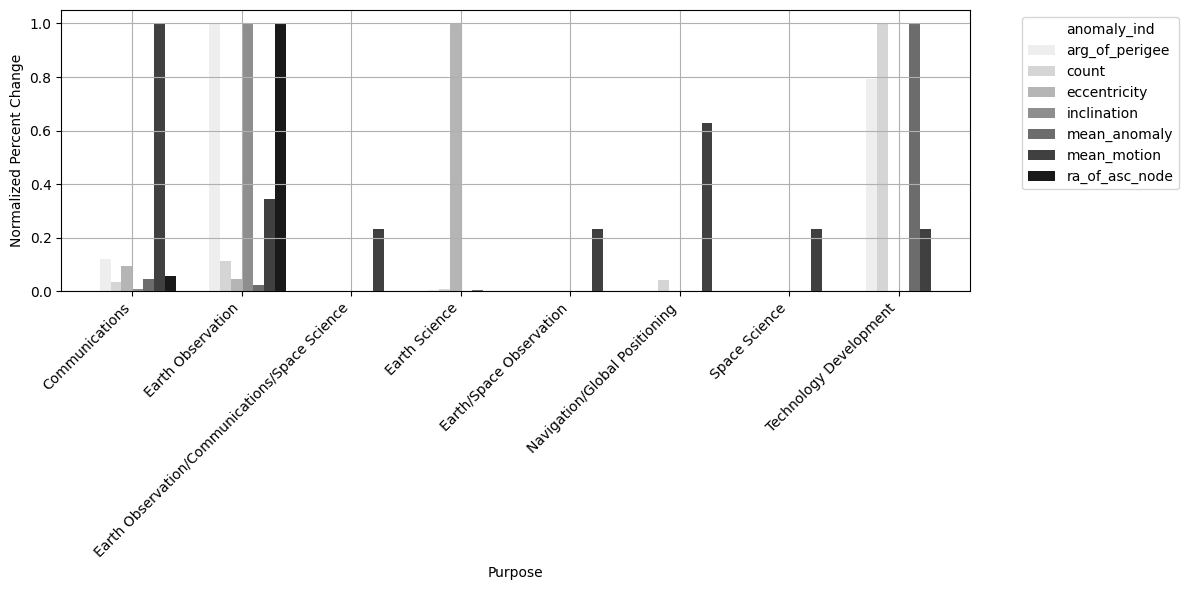

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plot_data = percent_change_pivot.applymap(lambda x: float(x.strip('%')))
normalized_data = (plot_data - plot_data.min()) / (plot_data.max() - plot_data.min())

ax = normalized_data.plot(kind='bar', figsize=(12, 6), width=0.8, 
                        colormap='Greys', alpha=0.9)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Percent Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

PLOTS

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

def plot_viusals(df, name): 

        print(f"TOTAL ANOMALIES IN {name}:\t {df['anomaly_ind'].sum()}")

    # Anomalies by Hour   
        hourly_counts = df.groupby(df['datetime'].dt.hour)['anomaly_ind'].sum().reset_index()
        hourly_counts.columns = ['hour', 'anomalies']

        hourly_counts = hourly_counts.sort_values('hour')

        plt.figure(figsize=(12, 3))
        sns.barplot(data=hourly_counts, x='hour', y='anomalies', color='royalblue')
        plt.title('Anomalies by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Anomalies')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    # Anomalies by Month
        monthly_counts = df.groupby(df['datetime'].dt.month)['anomaly_ind'].sum().reset_index()
        monthly_counts.columns = ['month', 'anomalies']

        monthly_counts = monthly_counts.sort_values('month')
        plt.figure(figsize=(12, 3))
        sns.barplot(data=monthly_counts, x='month', y='anomalies', color='royalblue')
        plt.title('Anomalies by Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Anomalies')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    #Anomalies over time year-month
        monthly_anomalies = df.groupby(df['datetime'].dt.to_period('M'))['anomaly_ind'].sum().reset_index()
        monthly_anomalies['datetime'] = monthly_anomalies['datetime'].dt.to_timestamp()

        plt.figure(figsize=(15, 4))
        plt.plot(monthly_anomalies['datetime'], monthly_anomalies['anomaly_ind'], 
                marker='o', linestyle='-', linewidth=2, markersize=6)

        plt.title('Anomalies Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Anomalies')

        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        plt.show()

        #Anomalies by Discipline
        plot_data = df[df['Discipline']!='Unidentified']
        grouped_data = plot_data.groupby([plot_data['datetime'].dt.to_period('M'), 'Discipline'])['anomaly_ind'].sum().reset_index()

        grouped_data['datetime'] = grouped_data['datetime'].dt.to_timestamp()
        plt.figure(figsize=(15, 4))

        for disc in grouped_data['Discipline'].unique():
                data = grouped_data[grouped_data['Discipline'] == disc]
                plt.plot(data['datetime'], data['anomaly_ind'], 
                        label=disc, marker='o', linewidth=2, markersize=6)

        plt.title('Anomalies by Discipline Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Anomalies')
        plt.legend(title='Discipline', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()

        plt.show()


        #Anomalies map
        anom_df = df[df['anomaly_ind']==1]
        anom_map_data = anom_df[anom_df['Discipline']!='0']
        
        import plotly.graph_objects as go

        colors = [
                '#FF6B6B',  # coral red
                '#4ECDC4',  # turquoise
                '#45B7D1',  # sky blue
                '#96CEB4',  # sage green
                '#FFEEAD',  # cream yellow
                '#D4A5A5',  # dusty rose
                '#9B5DE5',  # purple
                '#F15BB5',  # pink
                '#FEE440',  # bright yellow
                '#00BBF9',  # bright blue
                '#00F5D4',  # mint
                '#404040',  # charcoal
                '#000000',  # black
                ]

        unique_disciplines = anom_map_data['Discipline'].unique()
        color_dict = dict(zip(unique_disciplines, colors[:len(unique_disciplines)]))

        fig = go.Figure()

        fig.add_trace(go.Scattergeo(
        lon=anom_map_data['x'],
        lat=anom_map_data['y'],
        mode='markers',
        marker=dict(
                size=5,
                color=[color_dict[p] for p in anom_map_data['Discipline']],
                opacity=0.8,
                symbol='circle'
        ),
        text=anom_map_data.apply(lambda row: f'Discipline: {row["Discipline"]}<br>Anomaly Count: {row["anom_count"]}', axis=1),
        name='Satellites'
        ))

        fig.update_layout(
        title='Positions of Anomalies',
        geo=dict(
                projection_type='equirectangular',
                showland=True,
                showocean=True,
                showcoastlines=True,
                showcountries=True,
                oceancolor='rgb(238, 245, 252)',
                landcolor='rgb(243, 243, 243)',
                coastlinecolor='rgb(80, 80, 80)',
                countrycolor='rgb(80, 80, 80)',
                bgcolor='rgba(255, 255, 255, 0)',
                framecolor='rgba(255, 255, 255, 0)',
                showframe=False
        ),
        paper_bgcolor='rgba(255, 255, 255, 1)',
        plot_bgcolor='rgba(255, 255, 255, 1)',
        margin=dict(l=0, r=0, t=30, b=0)
        )

        for disc in unique_disciplines:
                fig.add_trace(go.Scattergeo(
                        lon=[None],
                        lat=[None],
                        mode='markers',
                        marker=dict(size=15, color=color_dict[disc]),
                        name=disc,
                        showlegend=True
                ))

        fig.show()


        colors = [
                '#FF6B6B',  # coral red
                '#4ECDC4',  # turquoise
                '#45B7D1',  # sky blue
                '#96CEB4',  # sage green
                '#FFEEAD',  # cream yellow
                '#D4A5A5',  # dusty rose
                '#9B5DE5',  # purple
                '#F15BB5',  # pink
                '#FEE440',  # bright yellow
                '#00BBF9',  # bright blue
                '#00F5D4',  # mint
                '#404040',  # charcoal
                '#000000',  # black
                ]

        unique_disciplines = anom_map_data['Discipline'].unique()
        color_dict = dict(zip(unique_disciplines, colors[:len(unique_disciplines)]))

        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
        x=anom_map_data['x'],
        y=anom_map_data['y'],
        z=anom_map_data['z'],
        mode='markers',
        marker=dict(
                size=5,
                color=[color_dict[p] for p in anom_map_data['Discipline']],
                opacity=0.8
        ),
        text=anom_map_data.apply(lambda row: f'Discipline: {row["Discipline"]}<br>Anomaly Count: {row["anom_count"]}<br>Altitude: {row["z"]}<br>Satellite: {row["SATNAME"]}<br>NORAD ID: {row["NORAD_CAT_ID"]}', axis=1),
        name='Satellites',
        hoverinfo='text'
        ))

        fig.update_layout(
        title='3D Positions of Anomalies',
        scene=dict(
                xaxis_title='Longitude',
                yaxis_title='Latitude',
                zaxis_title='Altitude'
        ),
        margin=dict(l=0, r=0, t=30, b=0)
        )

        for disc in unique_disciplines:
                fig.add_trace(go.Scatter3d(
                        x=[None], y=[None], z=[None],
                        mode='markers',
                        marker=dict(size=5, color=color_dict[disc]),
                        name=disc,
                        showlegend=True
                ))

        fig.write_html(f"satellite_anomalies_3d_{name}.html")

In [ ]:
tle_df['Discipline'].unique()

In [ ]:
plot_viusals(all_pre_df,f"all_pre_df_{all_pre_df['datetime'].max().strftime('%Y-%m-%d')}_to_{all_pre_df['datetime'].min().strftime('%Y-%m-%d')}")

In [ ]:
discipline_totals = {disc: lead_up[lead_up['Discipline'] == disc][anomaly_columns].sum().sum() 
                    for disc in disciplines}

active_disciplines = [disc for disc, total in discipline_totals.items() 
                     if total > 0 and disc not in ['Engineering', 'Astronomy', 'Solar Physics']]

n_rows = (len(active_disciplines) + 2) // 3  # 3 plots per row
n_cols = min(3, len(active_disciplines))

colors = ['#000000', '#333333', '#666666', '#999999', '#BBBBBB', '#DDDDDD']

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
if n_rows > 1:
    axs = axs.flatten()
elif n_rows == 1:
    axs = [axs] if n_cols == 1 else axs

for idx, discipline in enumerate(active_disciplines):
    discipline_data = lead_up[lead_up['Discipline'] == discipline]
    
    monthly_disc_anomalies = discipline_data.groupby(discipline_data['datetime'].dt.to_period('M'))[anomaly_columns].sum().reset_index()
    monthly_disc_anomalies['datetime'] = monthly_disc_anomalies['datetime'].dt.to_timestamp()
    
    axs[idx].stackplot(monthly_disc_anomalies['datetime'], 
                      [monthly_disc_anomalies[col] for col in anomaly_columns],
                      labels=[col.replace('anom_', '').replace('_', ' ').title() for col in anomaly_columns],
                      colors=colors,
                      alpha=0.9)
    
    axs[idx].set_title(f'Discipline: {discipline}', fontsize=12, pad=10)
    axs[idx].set_xlabel('Date', fontsize=10)
    axs[idx].set_ylabel('Number of Anomalies', fontsize=10)
    axs[idx].tick_params(axis='x', rotation=45)
    axs[idx].grid(True, alpha=0.2)
    
    axs[idx].legend(loc='upper right', fontsize=8)
    
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['right'].set_visible(False)

for idx in range(len(active_disciplines), len(axs)):
    fig.delaxes(axs[idx])

plt.suptitle('Orbital Element Anomalies by RSO Discipline', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Plot on 2D
# include date of launch
# look for new launch

********************* Prod Code